<a href="https://colab.research.google.com/github/faizan65-debug/Hello/blob/main/Horse_Human_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
import sys
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Cell 2 — upload ZIP from local PC or mount Google Drive
# Option A — upload file from your computer (recommended for one-off)
from google.colab import files
uploaded = files.upload()   # picks files from your PC
zip_path = next(iter(uploaded))   # first uploaded filename
print("Uploaded:", zip_path)

Saving horse-or-human.zip to horse-or-human.zip
Uploaded: horse-or-human.zip


In [17]:
import os

print("Files currently in /content:")
print(os.listdir("/content"))


Files currently in /content:
['.config', 'horse-or-human.zip', '.ipynb_checkpoints', 'horse_or_human.zip', 'sample_data']


In [18]:
# Adjust name if your uploaded file is different (e.g. horse-or-human.zip, horse_human.zip etc.)
zip_path = "/content/horse-or-human.zip"

!rm -rf /content/horse-or-human   # clear any old folder
!mkdir /content/horse-or-human
!unzip -q "$zip_path" -d /content/horse-or-human

print("After unzip, contents are:")
!ls -R /content/horse-or-human | head -40

After unzip, contents are:
/content/horse-or-human:
horses
humans

/content/horse-or-human/horses:
horse01-0.png
horse01-1.png
horse01-2.png
horse01-3.png
horse01-4.png
horse01-5.png
horse01-6.png
horse01-7.png
horse01-8.png
horse01-9.png
horse02-0.png
horse02-1.png
horse02-2.png
horse02-3.png
horse02-4.png
horse02-5.png
horse02-6.png
horse02-7.png
horse02-8.png
horse02-9.png
horse03-0.png
horse03-1.png
horse03-2.png
horse03-3.png
horse03-4.png
horse03-5.png
horse03-6.png
horse03-7.png
horse03-8.png
horse03-9.png
horse04-0.png
horse04-1.png
horse04-2.png
horse04-3.png
horse04-4.png


In [19]:
list_top('/content/horse-or-human')

Top-level in /content/horse-or-human :
 ['horses', 'humans']

Subfolders (first level):
  horses -> 500 files
  humans -> 527 files


In [20]:
# Cell 3 — inspect
import os

def list_top(dirpath):
    print("Top-level in", dirpath, ":\n", os.listdir(dirpath))
    print("\nSubfolders (first level):")
    for name in sorted(os.listdir(dirpath)):
        p = os.path.join(dirpath, name)
        if os.path.isdir(p):
            print(" ", name, "->", len(os.listdir(p)), "files")

list_top('/content/horse-or-human')

Top-level in /content/horse-or-human :
 ['horses', 'humans']

Subfolders (first level):
  horses -> 500 files
  humans -> 527 files


In [21]:
# Cell 4 — auto-organize if images are not already in class subfolders
import shutil, re

root = '/content/horse-or-human'
subfolders = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]
print("Detected subfolders:", subfolders)

if not subfolders:
    print("No class subfolders detected. Attempting to auto-split by filename keywords...")
    horses_dir = os.path.join(root, 'horses')
    humans_dir = os.path.join(root, 'humans')
    os.makedirs(horses_dir, exist_ok=True)
    os.makedirs(humans_dir, exist_ok=True)
    moved = 0
    for fname in os.listdir(root):
        fpath = os.path.join(root, fname)
        if os.path.isfile(fpath):
            name = fname.lower()
            if 'horse' in name:
                shutil.move(fpath, os.path.join(horses_dir, fname)); moved += 1
            elif 'human' in name or 'person' in name:
                shutil.move(fpath, os.path.join(humans_dir, fname)); moved += 1
    print("Moved", moved, "files. New contents:")
    list_top(root)
else:
    print("Looks good — class subfolders present.")


Detected subfolders: ['horses', 'humans']
Looks good — class subfolders present.


In [22]:
# Cell 5 — data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (150, 150)   # resize images to this
BATCH_SIZE = 32
DATA_DIR = '/content/horse-or-human'  # root directory with class subfolders

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


In [23]:
# Cell 6 — model
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Cell 7 — callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "/content/best_horse_human_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

print("Checkpoint path:", checkpoint_path)


Checkpoint path: /content/best_horse_human_model.h5


In [25]:
# Cell 8 — training
EPOCHS = 5  # tweak as needed
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6467 - loss: 0.6743

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 554ms/step - accuracy: 0.6461 - loss: 0.6737 - val_accuracy: 0.5122 - val_loss: 0.7879
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6899 - loss: 0.5903

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.6909 - loss: 0.5895 - val_accuracy: 0.5756 - val_loss: 0.5413
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7970 - loss: 0.4594

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.7968 - loss: 0.4594 - val_accuracy: 0.9171 - val_loss: 0.3811
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8162 - loss: 0.4203

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.8170 - loss: 0.4193 - val_accuracy: 0.9512 - val_loss: 0.3066
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.8528 - loss: 0.3383 - val_accuracy: 0.8293 - val_loss: 0.3249


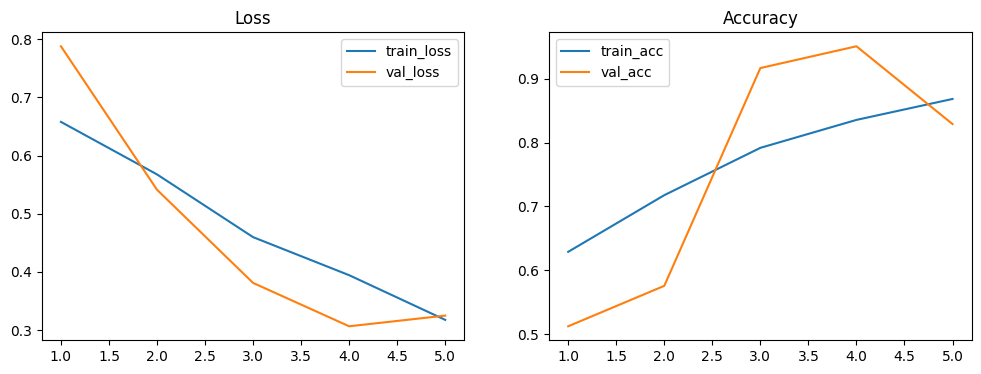

In [26]:
# Cell 9 — plot
import matplotlib.pyplot as plt

acc = history.history.get('accuracy', history.history.get('acc'))
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, loss, label='train_loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [27]:
# Cell 10 — load best model and evaluate on validation set
from tensorflow.keras.models import load_model
best = load_model(checkpoint_path)
val_loss, val_acc = best.evaluate(validation_generator, verbose=1)
print("Best model validation — loss:", val_loss, "acc:", val_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.8791 - loss: 0.3301
Best model validation — loss: 0.30946093797683716 acc: 0.9219512343406677


In [28]:
# Cell 11 — predict on a single image
import numpy as np
from tensorflow.keras.preprocessing import image
import glob

# pick any image from validation folder for demo:
val_class_dirs = list(validation_generator.class_indices.keys())
print("Classes:", val_class_dirs)
sample_paths = glob.glob(os.path.join(DATA_DIR, val_class_dirs[0], '*'))
if not sample_paths:
    sample_paths = glob.glob(os.path.join(DATA_DIR, val_class_dirs[1], '*'))
sample_img = sample_paths[0]
print("Sample image:", sample_img)

img = image.load_img(sample_img, target_size=IMG_SIZE)
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)
pred = best.predict(x)[0][0]
print("Pred raw:", pred)
print("Pred class:", ("human" if pred>=0.5 else "horse"), " (>=0.5 => human)")


Classes: ['horses', 'humans']
Sample image: /content/horse-or-human/horses/horse08-9.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
Pred raw: 0.26886776
Pred class: horse  (>=0.5 => human)


In [32]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import tensorflow as tf

# Reuse the trained model (adjust if your model variable is different)
# If you loaded it with load_model, use: model = best

# Same rescaling as training (1./255)
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Create upload widget
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Output widget for predictions
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """Create prediction for uploaded image and print result."""
    # Load and preprocess
    image = tf.keras.utils.load_img(file, target_size=(150, 150))  # match your IMG_SIZE
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    # Predict
    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction > 0.5:
            print(f"{filename} → Human ({prediction:.3f})")
        else:
            print(f"{filename} → Horse ({prediction:.3f})")

def on_upload_change(change):
    """Handle uploaded file(s) and run prediction."""
    out.clear_output()
    for filename, file_info in uploader.value.items():
        file_bytes = file_info['content']
        # Save temp file
        tmp_path = "/content/" + filename
        with open(tmp_path, "wb") as f:
            f.write(file_bytes)
        # Predict
        file_predict(filename, tmp_path, out)

# Connect the callback
uploader.observe(on_upload_change, names="value")


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

In [33]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# If you trained with a variable "best", reassign: model = best
# Otherwise ensure "model" is your trained model

# Same rescaling as training (1./255)
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Create upload widget
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Output widget for predictions
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """Create prediction for uploaded image, show image + result."""
    # Load and preprocess
    image = tf.keras.utils.load_img(file, target_size=(150, 150))  # match your IMG_SIZE
    image_arr = tf.keras.utils.img_to_array(image)
    image_arr = rescale_layer(image_arr)
    image_arr = np.expand_dims(image_arr, axis=0)

    # Predict
    prediction = model.predict(image_arr, verbose=0)[0][0]
    label = "Human" if prediction > 0.5 else "Horse"

    with out:
        # Show image
        plt.imshow(tf.keras.utils.load_img(file))
        plt.axis("off")
        plt.title(f"{filename} → {label} ({prediction:.3f})")
        plt.show()

def on_upload_change(change):
    """Handle uploaded file(s) and run prediction."""
    out.clear_output()
    for filename, file_info in uploader.value.items():
        file_bytes = file_info['content']
        # Save temp file
        tmp_path = "/content/" + filename
        with open(tmp_path, "wb") as f:
            f.write(file_bytes)
        # Predict and display
        file_predict(filename, tmp_path, out)

# Connect the callback
uploader.observe(on_upload_change, names="value")


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()